# EDA

In [3]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

root_dir = 'PolyMNIST/MMNIST'
splits = ['train', 'test']
modalities = sorted(os.listdir(os.path.join(root_dir, 'train')))

def extract_label(fname):
    base = os.path.splitext(os.path.basename(fname))[0]
    m = re.match(r'^(\d+)', base)
    return int(m.group(1)) if m else None

records = []
for split in splits:
    for mod in modalities:
        folder = os.path.join(root_dir, split, mod)
        for fp in glob.glob(os.path.join(folder, '*.png')):
            lbl = extract_label(fp)
            records.append({
                'split': split,
                'modality': mod,
                'filepath': fp,
                'label': lbl
            })
df = pd.DataFrame(records)
print("–– Primeras filas del DataFrame ––")
print(df.head(), '\n')

print("–– Conteo imágenes por split/modality ––")
print(df.groupby(['split','modality']).size(), '\n')

print("–– Distribución de clases en TRAIN ––")
print(df[df.split=='train'].groupby('label').size(), '\n')

–– Primeras filas del DataFrame ––
   split modality                           filepath  label
0  train       m0  PolyMNIST/MMNIST\train\m0\0.0.png      0
1  train       m0  PolyMNIST/MMNIST\train\m0\0.1.png      0
2  train       m0  PolyMNIST/MMNIST\train\m0\0.2.png      0
3  train       m0  PolyMNIST/MMNIST\train\m0\0.3.png      0
4  train       m0  PolyMNIST/MMNIST\train\m0\0.4.png      0 

–– Conteo imágenes por split/modality ––
split  modality
test   m0          10000
       m1          10000
       m2          10000
       m3          10000
       m4          10000
train  m0          60000
       m1          60000
       m2          60000
       m3          60000
       m4          60000
dtype: int64 

–– Distribución de clases en TRAIN ––
label
0       50
1       50
2       50
3       50
4       50
        ..
6737     5
6738     5
6739     5
6740     5
6741     5
Length: 6742, dtype: int64 



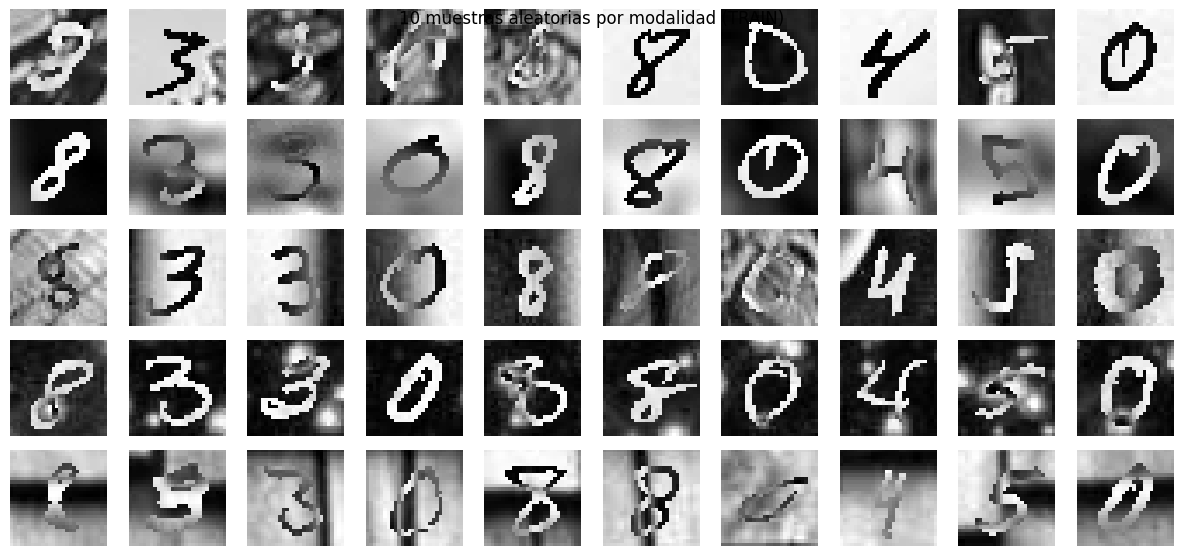

In [4]:
fig, axes = plt.subplots(len(modalities), 10, figsize=(12, 6))
for i, mod in enumerate(modalities):
    samp = df[(df.split=='train') & (df.modality==mod)].sample(10, random_state=0)
    for j,(idx,row) in enumerate(samp.iterrows()):
        img = Image.open(row.filepath).convert('L')
        axes[i,j].imshow(img, cmap='gray')
        axes[i,j].axis('off')
    axes[i,0].set_ylabel(mod, rotation=0, labelpad=20)
plt.suptitle("10 muestras aleatorias por modalidad (TRAIN)", y=0.92)
plt.tight_layout()
plt.show()

In [5]:
stats = []
for mod, grp in df[df.split=='train'].groupby('modality'):
    paths = grp.filepath.sample(1000, random_state=1)
    # carga y convierte a array gris
    arrs = np.stack([np.array(Image.open(p).convert('L')) for p in paths])
    stats.append({
        'modality': mod,
        'mean': float(arrs.mean()),
        'std':  float(arrs.std()),
        'min':  int(arrs.min()),
        'max':  int(arrs.max())
    })
df_stats = pd.DataFrame(stats)
print("–– Estadísticas de píxel por modalidad (1k muestras) ––")
print(df_stats, '\n')


–– Estadísticas de píxel por modalidad (1k muestras) ––
  modality        mean        std  min  max
0       m0  130.939038  74.498847    0  255
1       m1   99.898761  48.017121    2  253
2       m2  125.385362  49.163927   20  249
3       m3   66.224987  75.563916    0  255
4       m4  133.911483  62.314983    0  255 



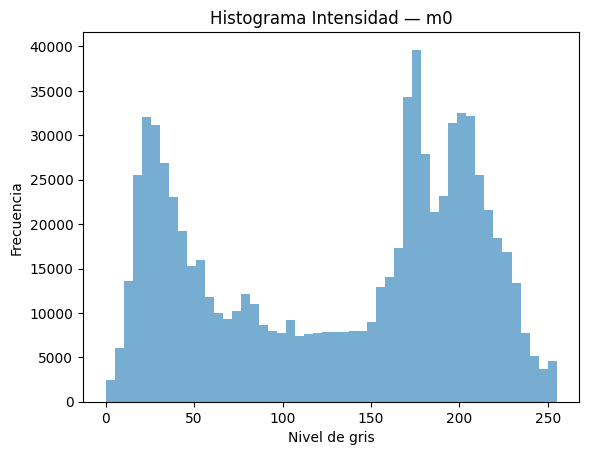

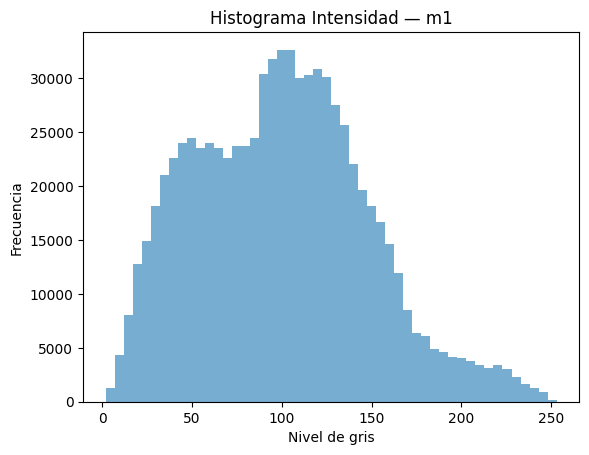

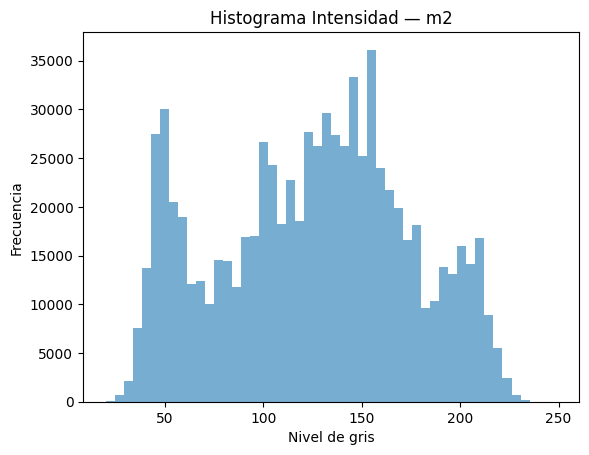

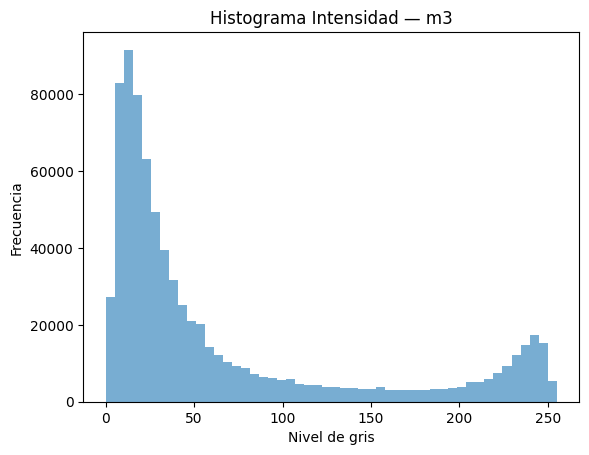

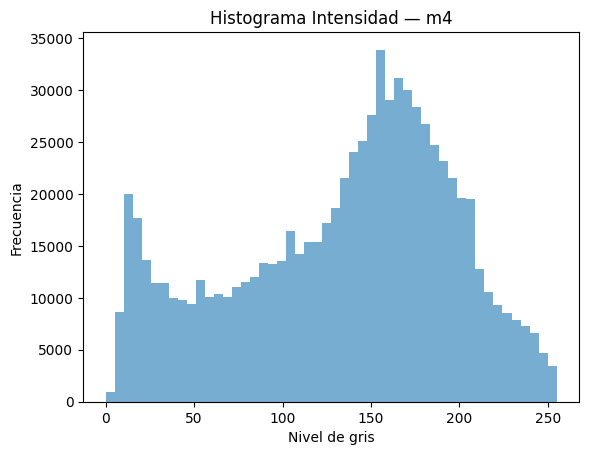

In [6]:
for mod in modalities:
    paths = df[(df.split=='train') & (df.modality==mod)].filepath.sample(1000, random_state=1)
    vals = np.hstack([np.array(Image.open(p).convert('L')).ravel() for p in paths])
    plt.hist(vals, bins=50, alpha=0.6)
    plt.title(f'Histograma Intensidad — {mod}')
    plt.xlabel('Nivel de gris'); plt.ylabel('Frecuencia')
    plt.show()

In [7]:
def get_bbox(img, thresh=10):
    arr = np.array(img.convert('L'))
    mask = arr > thresh
    ys, xs = np.where(mask)
    if ys.size==0: return (0,0,0,0)
    return xs.min(), ys.min(), xs.max(), ys.max()

bb_records = []
for mod, grp in df[df.split=='train'].groupby('modality'):
    sample = grp.filepath.sample(500, random_state=2)
    for p in sample:
        img = Image.open(p)
        x0,y0,x1,y1 = get_bbox(img)
        bb_records.append({
            'modality': mod,
            'width':  x1-x0,
            'height': y1-y0,
            'x_ctr':  (x0+x1)/2,
            'y_ctr':  (y0+y1)/2
        })
df_bb = pd.DataFrame(bb_records)
print("–– Estadísticas de bounding‐box (500 muestras) ––")
print(df_bb.groupby('modality')[['width','height']].describe(), '\n')


–– Estadísticas de bounding‐box (500 muestras) ––
          width                                                 height  \
          count    mean       std   min   25%   50%   75%   max  count   
modality                                                                 
m0        500.0  26.996  0.089443  25.0  27.0  27.0  27.0  27.0  500.0   
m1        500.0  26.994  0.134164  24.0  27.0  27.0  27.0  27.0  500.0   
m2        500.0  27.000  0.000000  27.0  27.0  27.0  27.0  27.0  500.0   
m3        500.0  26.998  0.044721  26.0  27.0  27.0  27.0  27.0  500.0   
m4        500.0  27.000  0.000000  27.0  27.0  27.0  27.0  27.0  500.0   

                                                          
            mean       std   min   25%   50%   75%   max  
modality                                                  
m0        26.998  0.044721  26.0  27.0  27.0  27.0  27.0  
m1        26.980  0.260260  23.0  27.0  27.0  27.0  27.0  
m2        27.000  0.000000  27.0  27.0  27.0  27.0  27.0  
m3 

In [ ]:
cross = df[df.split=='train'].pivot_table(
    index='filepath', columns='modality', values='label'
).reset_index(drop=True)
print("¿Todas las modalidades coinciden en el mismo dígito?")
print((cross.nunique(axis=1)==1).mean(), "(proporción de coincidencias)\n")


¿Todas las modalidades coinciden en el mismo dígito?
1.0 ✓  (proporción de coincidencias)



In [9]:
stats = []
for mod in df[df.split=='train'].modality.unique():
    sample_paths = df[(df.split=='train') & (df.modality==mod)].filepath.sample(2000, random_state=0)
    imgs = np.stack([np.array(Image.open(p).convert('L')) for p in sample_paths])
    stats.append({
        'modality': mod,
        'mean': float(imgs.mean()),
        'std':  float(imgs.std()),
        'min':  int(imgs.min()),
        'max':  int(imgs.max()),
    })
stats_df = pd.DataFrame(stats).set_index('modality')
print("Estadísticas de píxel por modalidad (2 000 muestras):")
print(stats_df, "\n")

Estadísticas de píxel por modalidad (2 000 muestras):
                mean        std  min  max
modality                                 
m0        128.259818  74.103411    0  255
m1         99.258878  48.962749    0  253
m2        125.981822  49.071720    6  249
m3         65.872785  75.481263    0  255
m4        133.770108  62.226560    0  255 



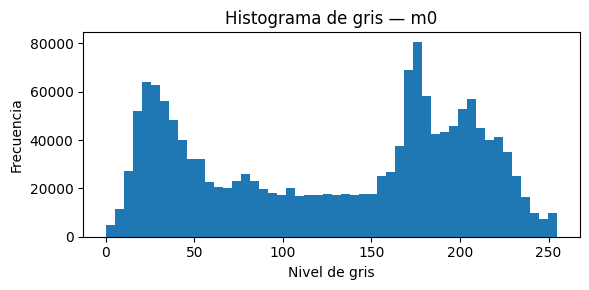

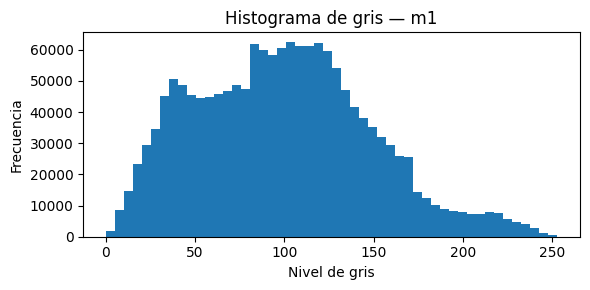

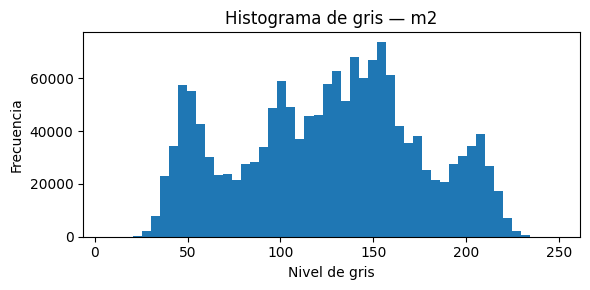

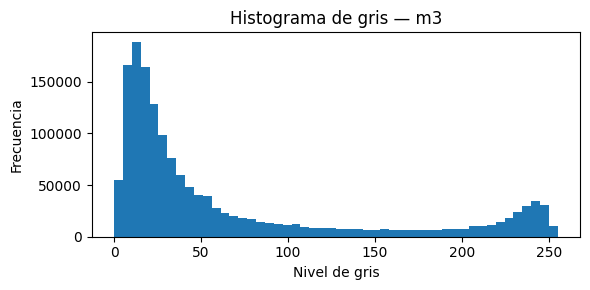

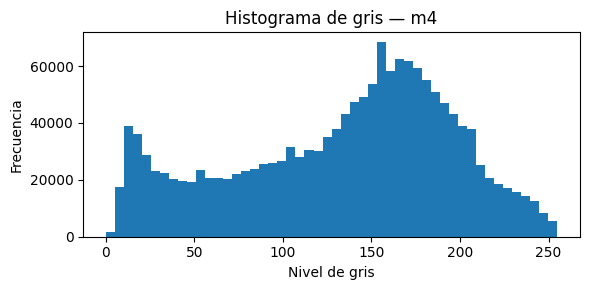

In [10]:
for mod in stats_df.index:
    sample_paths = df[(df.split=='train') & (df.modality==mod)].filepath.sample(2000, random_state=0)
    pixels = np.hstack([np.array(Image.open(p).convert('L')).ravel() for p in sample_paths])
    plt.figure(figsize=(6,3))
    plt.hist(pixels, bins=50)
    plt.title(f'Histograma de gris — {mod}')
    plt.xlabel('Nivel de gris')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

In [11]:
def get_bbox(arr, thresh=10):
    mask = arr > thresh
    ys, xs = np.where(mask)
    if ys.size==0: return None
    return xs.min(), ys.min(), xs.max(), ys.max()

bb_stats = []
for mod in df[df.split=='train'].modality.unique():
    sample = df[(df.split=='train') & (df.modality==mod)].filepath.sample(1000, random_state=1)
    for p in sample:
        arr = np.array(Image.open(p).convert('L'))
        box = get_bbox(arr)
        if box:
            x0,y0,x1,y1 = box
            bb_stats.append({
                'modality': mod,
                'width':  x1-x0,
                'height': y1-y0,
                'x_ctr':  (x0+x1)/2,
                'y_ctr':  (y0+y1)/2
            })
bb_df = pd.DataFrame(bb_stats)
print("Descripción de bounding‐boxes por modalidad:")
print(bb_df.groupby('modality')[['width','height']].describe(), "\n")


Descripción de bounding‐boxes por modalidad:
           width                                                  height  \
           count    mean       std   min   25%   50%   75%   max   count   
modality                                                                   
m0        1000.0  26.993  0.158038  23.0  27.0  27.0  27.0  27.0  1000.0   
m1        1000.0  26.998  0.063246  25.0  27.0  27.0  27.0  27.0  1000.0   
m2        1000.0  27.000  0.000000  27.0  27.0  27.0  27.0  27.0  1000.0   
m3        1000.0  26.995  0.130353  23.0  27.0  27.0  27.0  27.0  1000.0   
m4        1000.0  27.000  0.000000  27.0  27.0  27.0  27.0  27.0  1000.0   

                                                          
            mean       std   min   25%   50%   75%   max  
modality                                                  
m0        26.998  0.063246  25.0  27.0  27.0  27.0  27.0  
m1        26.996  0.099970  24.0  27.0  27.0  27.0  27.0  
m2        27.000  0.000000  27.0  27.0  27.0  27.0 

In [12]:
snr_list = []
for mod in df[df.split=='train'].modality.unique():
    sample = df[(df.split=='train') & (df.modality==mod)].filepath.sample(500, random_state=2)
    for p in sample:
        img = Image.open(p).convert('L')
        arr = np.array(img)
        box = get_bbox(arr)
        if box:
            x0,y0,x1,y1 = box
            digit = arr[y0:y1+1, x0:x1+1]
            background = np.concatenate([
                arr[:y0,:].ravel(), arr[y1+1:,:].ravel(),
                arr[y0:y1+1,:x0].ravel(), arr[y0:y1+1,x1+1:].ravel()
            ])
            snr_list.append({
                'modality': mod,
                'snr': digit.mean() / (background.std() + 1e-5)
            })
snr_df = pd.DataFrame(snr_list)
print("SNR (media dígito / σ fondo) por modalidad:")
print(snr_df.groupby('modality').snr.describe(), "\n")

c:\Users\dolan\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dolan\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\dolan\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


SNR (media dígito / σ fondo) por modalidad:
          count       mean        std        min        25%        50%  \
modality                                                                 
m0          2.0  12.693188   0.041412  12.663905  12.678546  12.693188   
m1          4.0  35.779173  10.169386  24.611925  30.933859  34.697300   
m2          0.0        NaN        NaN        NaN        NaN        NaN   
m3          1.0  14.908521        NaN  14.908521  14.908521  14.908521   
m4          0.0        NaN        NaN        NaN        NaN        NaN   

                75%        max  
modality                        
m0        12.707829  12.722471  
m1        39.542615  49.110166  
m2              NaN        NaN  
m3        14.908521  14.908521  
m4              NaN        NaN   



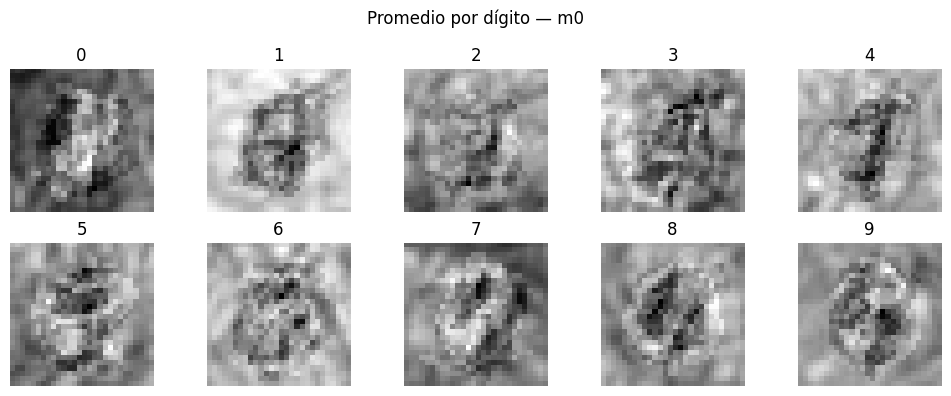

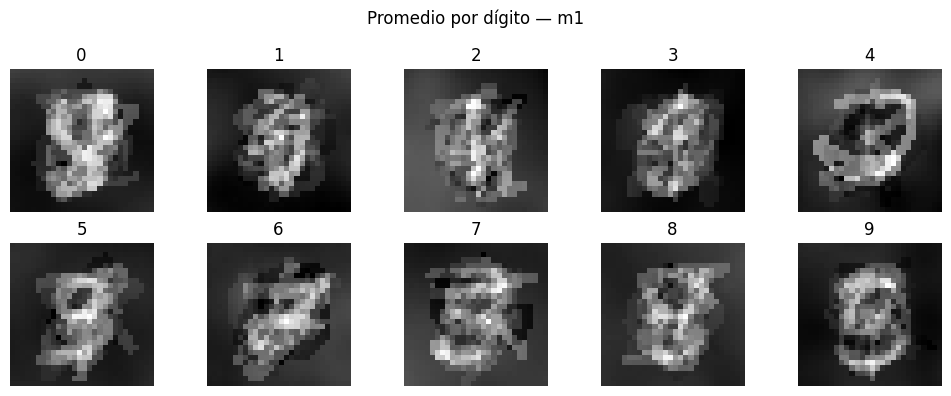

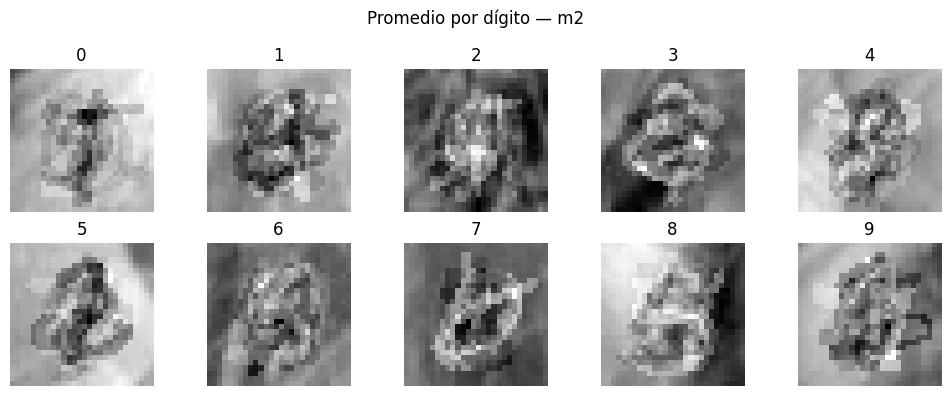

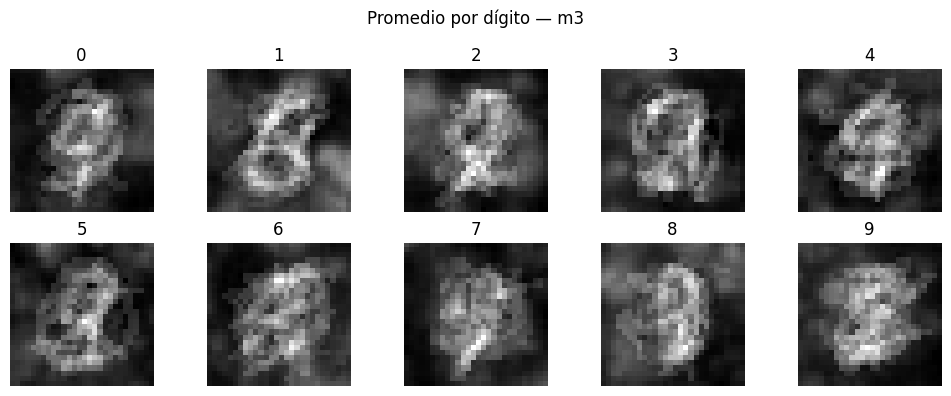

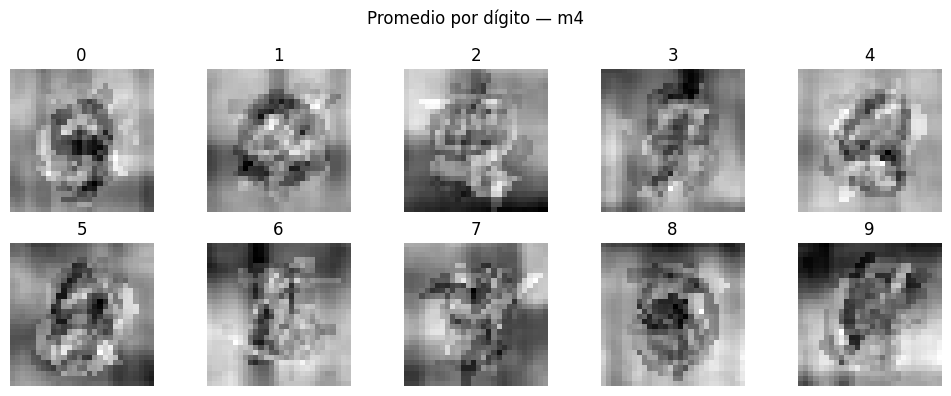

In [15]:
n_requested = 1000

for mod in df[df.split=='train'].modality.unique():
    fig, axes = plt.subplots(2,5, figsize=(10,4))
    fig.suptitle(f'Promedio por dígito — {mod}')
    for d in range(10):
        group = df[(df.split=='train') & (df.modality==mod) & (df.label==d)].filepath
        n_available = len(group)
        n = min(n_requested, n_available)             # <= población
        sample_paths = group.sample(n, random_state=3, replace=False)
        
        arrs = np.stack([np.array(Image.open(p).convert('L')) for p in sample_paths])
        avg = arrs.mean(axis=0)
        
        ax = axes.flat[d]
        ax.imshow(avg, cmap='gray')
        ax.set_title(str(d))
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
import tensorflow as tf

IMG_HEIGHT, IMG_WIDTH = 28, 28
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
num_classes = df.label.nunique()

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)               
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0                   
    return img, label

train_df = df[df.split == 'train']
test_df  = df[df.split == 'test']

train_ds = (
    tf.data.Dataset
      .from_tensor_slices((train_df.filepath.values, train_df.label.values))
      .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
      .shuffle(10_000)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)
test_ds = (
    tf.data.Dataset
      .from_tensor_slices((test_df.filepath.values, test_df.label.values))
      .map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(AUTOTUNE)
)


# Red Neuronal

In [ ]:
model_simple = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_simple.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_simple = model_simple.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)


# CNN

In [ ]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    train_ds,
    epochs=15,
    validation_data=test_ds
)
